In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [29]:
climbers = pd.read_csv("archive(4)/climber_df.csv")
conversions = pd.read_csv("archive(4)/grades_conversion_table.csv")
routes = pd.read_csv("archive(4)/routes_rated.csv")

In [30]:
def cat(a):
    if a <= 44:
        return "Intermediate"
    elif a > 44 and a <= 57:
        return "Advanced"
    else:
        return "Expert"

In [31]:
climbers['skill level'] = climbers['grades_mean'].apply(cat)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

features = ['sex','height','weight','age','years_cl', 'grades_count', 'grades_first', 'grades_max']
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_pre_scale = climbers[features].to_numpy()
scaler = preprocessing.StandardScaler().fit(X_pre_scale)
X = scaler.transform(X_pre_scale)
y = climbers['skill level'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
splits = KFold(n_splits=10)

In [24]:
both = pd.DataFrame(columns = ['K', 'Mean', 'Standard Deviation'])

for k in range(1, 22, 2):
    scores = []
    for train_idx, val_idx in splits.split(X_train):
        X_subtrain = X_train[train_idx]
        X_val = X_train[val_idx]
        y_subtrain = y_train[train_idx]
        y_val = y_train[val_idx]
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_subtrain, y_subtrain)
        y_predict = clf.predict(X_val)
        scores.append(accuracy_score(y_val, y_predict))
    list_row = [k, np.mean(scores), np.std(scores)]
    both.loc[len(both)] = list_row

In [25]:
print(both)
print(np.max(both['Mean']))
best_k = 17

       K      Mean  Standard Deviation
0    1.0  0.777028            0.013849
1    3.0  0.813294            0.008104
2    5.0  0.824390            0.009022
3    7.0  0.824505            0.007490
4    9.0  0.830569            0.010640
5   11.0  0.832056            0.011021
6   13.0  0.834687            0.010921
7   15.0  0.834115            0.012330
8   17.0  0.837090            0.012067
9   19.0  0.835717            0.009731
10  21.0  0.835144            0.011225
0.8370896371363191


In [26]:
clf = KNeighborsClassifier(n_neighbors=best_k)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Testing Accuracy: ", accuracy_score(y_test, y_predict))
y_predict = clf.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_predict))

Testing Accuracy:  0.8449222323879232
Training Accuracy:  0.8518476146893948


C:\Users\julia\AppData\Local\Temp\ipykernel_16964\4144497089.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='seismic')


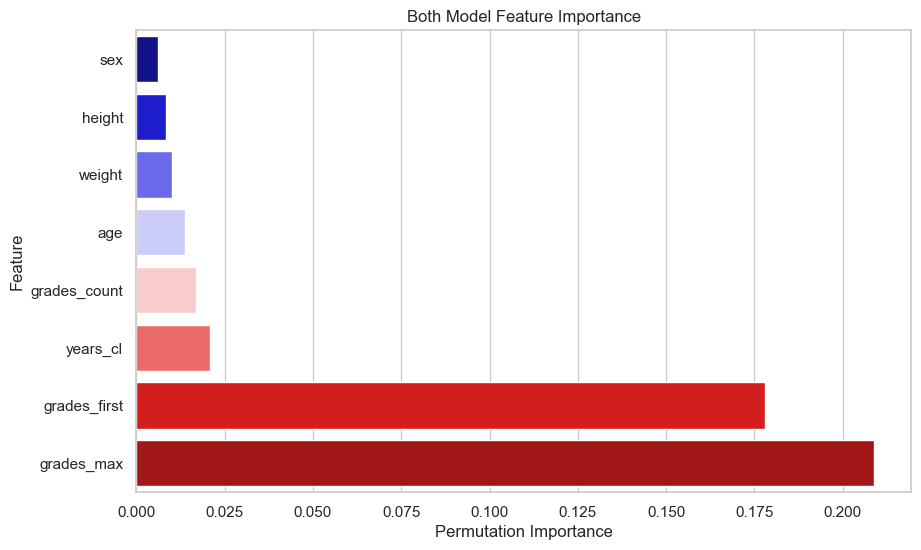

In [13]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X, y, n_repeats=10, random_state=0)
sorted_idx = result.importances_mean.argsort()

perm_importance_df = pd.DataFrame({'Feature': np.array(features)[sorted_idx],
                                   'Importance': result.importances_mean[sorted_idx]})
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='seismic')
plt.xlabel('Permutation Importance')
plt.title('Both Model Feature Importance')
plt.savefig('perm_imp_knn_both.png')
plt.show()

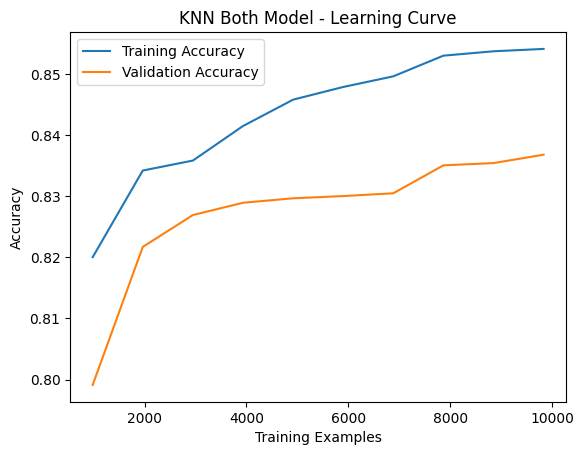

In [21]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy")

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('KNN Both Model - Learning Curve')
plt.savefig("learning_curve_knn_both.png")
plt.legend()
plt.show()

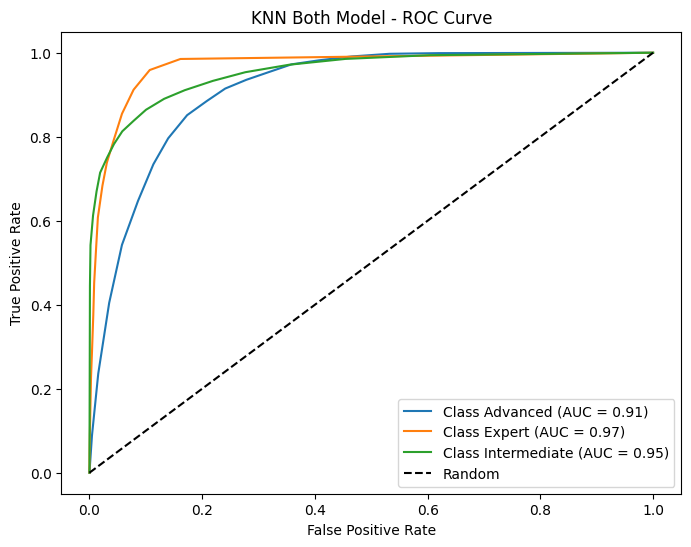

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder


clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=best_k))

y_numeric = label_encoder.fit_transform(y)
y_one_hot = label_binarize(y_numeric, classes=np.unique(y_numeric))
y_scores = cross_val_predict(clf, X, y_one_hot, cv=10, method="predict_proba")

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label="Class {} (AUC = {:.2f})".format(label_encoder.inverse_transform([i])[0], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Both Model - ROC Curve')

plt.legend()
plt.savefig("roc_both_knn.png")
plt.show()


['Advanced' 'Expert' 'Intermediate']


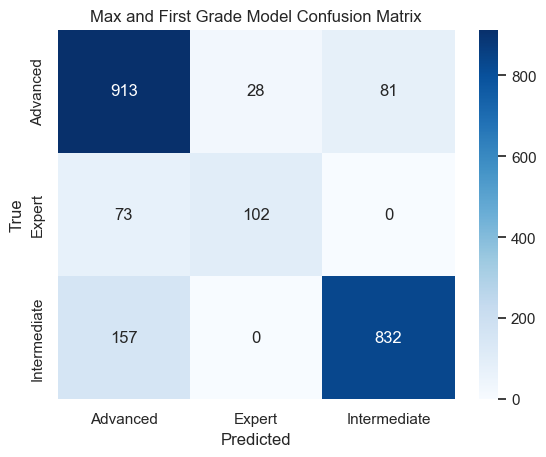

In [27]:
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predict)

print(np.unique(y))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",  xticklabels=['Advanced', 'Expert', 'Intermediate'], yticklabels=['Advanced', 'Expert', 'Intermediate'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Max and First Grade Model Confusion Matrix")
plt.savefig('both_conf_heatmap.png')
plt.show()

In [10]:
features = ['sex','height','weight','age','years_cl', 'grades_count', 'grades_first']
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_pre_scale = climbers[features].to_numpy()
scaler = preprocessing.StandardScaler().fit(X_pre_scale)
X = scaler.transform(X_pre_scale)
y = climbers['skill level'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
splits = KFold(n_splits=10)

In [11]:
first = pd.DataFrame(columns = ['K', 'Mean', 'Standard Deviation'])

for k in range(1, 22, 2):
    scores = []
    for train_idx, val_idx in splits.split(X_train):
        X_subtrain = X_train[train_idx]
        X_val = X_train[val_idx]
        y_subtrain = y_train[train_idx]
        y_val = y_train[val_idx]
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_subtrain, y_subtrain)
        y_predict = clf.predict(X_val)
        scores.append(accuracy_score(y_val, y_predict))
    list_row = [k, np.mean(scores), np.std(scores)]
    first.loc[len(first)] = list_row

In [12]:
print(first)
print(np.max(first['Mean']))
best_k = 21

       K      Mean  Standard Deviation
0    1.0  0.704724            0.013931
1    3.0  0.749799            0.007177
2    5.0  0.766959            0.011796
3    7.0  0.774395            0.012802
4    9.0  0.781603            0.013733
5   11.0  0.784120            0.014346
6   13.0  0.784691            0.015502
7   15.0  0.783662            0.014356
8   17.0  0.787667            0.014204
9   19.0  0.788696            0.012480
10  21.0  0.788810            0.013925
0.7888104609349462


In [13]:
clf = KNeighborsClassifier(n_neighbors=best_k)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Testing Accuracy: ", accuracy_score(y_test, y_predict))
y_predict = clf.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_predict))

Testing Accuracy:  0.7950594693504117
Training Accuracy:  0.8045990161308775


['Advanced' 'Expert' 'Intermediate']


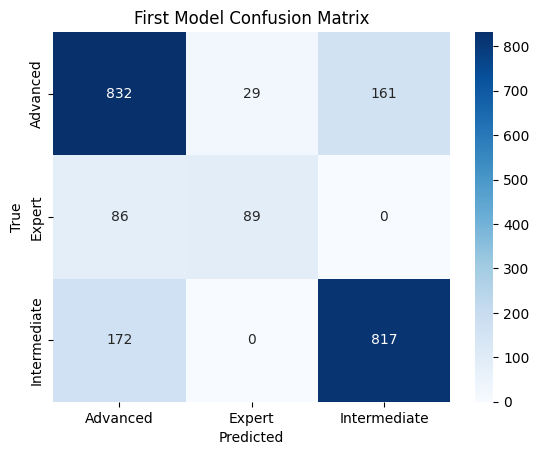

In [14]:
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predict)

print(np.unique(y))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",  xticklabels=['Advanced', 'Expert', 'Intermediate'], yticklabels=['Advanced', 'Expert', 'Intermediate'])
plt.xlabel("Predicted")
plt.ylabel("True")
# plt.savefig('neither_conf_heatmap.png')
plt.title("First Model Confusion Matrix")
plt.show()

In [15]:
features = ['sex','height','weight','age','years_cl', 'grades_count', 'grades_max']
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_pre_scale = climbers[features].to_numpy()
scaler = preprocessing.StandardScaler().fit(X_pre_scale)
X = scaler.transform(X_pre_scale)
y = climbers['skill level'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
splits = KFold(n_splits=10)

In [16]:
maxi = pd.DataFrame(columns = ['K', 'Mean', 'Standard Deviation'])

for k in range(1, 22, 2):
    scores = []
    for train_idx, val_idx in splits.split(X_train):
        X_subtrain = X_train[train_idx]
        X_val = X_train[val_idx]
        y_subtrain = y_train[train_idx]
        y_val = y_train[val_idx]
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_subtrain, y_subtrain)
        y_predict = clf.predict(X_val)
        scores.append(accuracy_score(y_val, y_predict))
    list_row = [k, np.mean(scores), np.std(scores)]
    maxi.loc[len(maxi)] = list_row

In [17]:
print(maxi)
print(np.max(maxi['Mean']))
best_k = 13

       K      Mean  Standard Deviation
0    1.0  0.742934            0.012349
1    3.0  0.769819            0.006437
2    5.0  0.781375            0.007972
3    7.0  0.783663            0.010742
4    9.0  0.788926            0.009329
5   11.0  0.789727            0.010844
6   13.0  0.793732            0.012002
7   15.0  0.790757            0.012359
8   17.0  0.792703            0.013380
9   19.0  0.793732            0.012499
10  21.0  0.793160            0.013376
0.7937318077803204


In [18]:
clf = KNeighborsClassifier(n_neighbors=best_k)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Testing Accuracy: ", accuracy_score(y_test, y_predict))
y_predict = clf.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_predict))

Testing Accuracy:  0.7913998170173834
Training Accuracy:  0.8257636426038211


['Advanced' 'Expert' 'Intermediate']


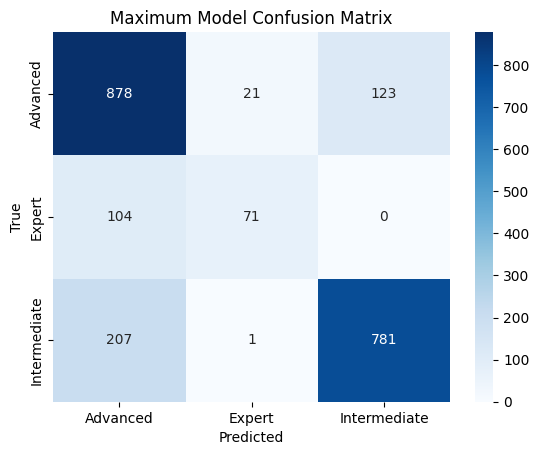

In [19]:
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predict)

print(np.unique(y))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",  xticklabels=['Advanced', 'Expert', 'Intermediate'], yticklabels=['Advanced', 'Expert', 'Intermediate'])
plt.xlabel("Predicted")
plt.ylabel("True")
# plt.savefig('neither_conf_heatmap.png')
plt.title("Maximum Model Confusion Matrix")
plt.show()

In [32]:
features = ['sex','height','weight','age','years_cl', 'grades_count']
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_pre_scale = climbers[features].to_numpy()
scaler = preprocessing.StandardScaler().fit(X_pre_scale)
X = scaler.transform(X_pre_scale)
y = climbers['skill level'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
splits = KFold(n_splits=10)

In [33]:
neither = pd.DataFrame(columns = ['K', 'Mean', 'Standard Deviation'])

for k in range(1, 22, 2):
    scores = []
    for train_idx, val_idx in splits.split(X_train):
        X_subtrain = X_train[train_idx]
        X_val = X_train[val_idx]
        y_subtrain = y_train[train_idx]
        y_val = y_train[val_idx]
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_subtrain, y_subtrain)
        y_predict = clf.predict(X_val)
        scores.append(accuracy_score(y_val, y_predict))
    list_row = [k, np.mean(scores), np.std(scores)]
    neither.loc[len(neither)] = list_row

In [34]:
print(neither)
print(np.max(neither['Mean']))
best_k = 21

       K      Mean  Standard Deviation
0    1.0  0.532890            0.016252
1    3.0  0.566984            0.015561
2    5.0  0.578766            0.011959
3    7.0  0.584257            0.011685
4    9.0  0.589634            0.013439
5   11.0  0.596727            0.011801
6   13.0  0.599357            0.015780
7   15.0  0.598214            0.017734
8   17.0  0.602333            0.017424
9   19.0  0.604278            0.019390
10  21.0  0.605079            0.019681
0.6050793069630599


In [35]:
clf = KNeighborsClassifier(n_neighbors=best_k)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Testing Accuracy: ", accuracy_score(y_test, y_predict))
y_predict = clf.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_predict))

Testing Accuracy:  0.6253430924062214
Training Accuracy:  0.6416885939823819


C:\Users\julia\AppData\Local\Temp\ipykernel_16964\497579574.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='seismic')


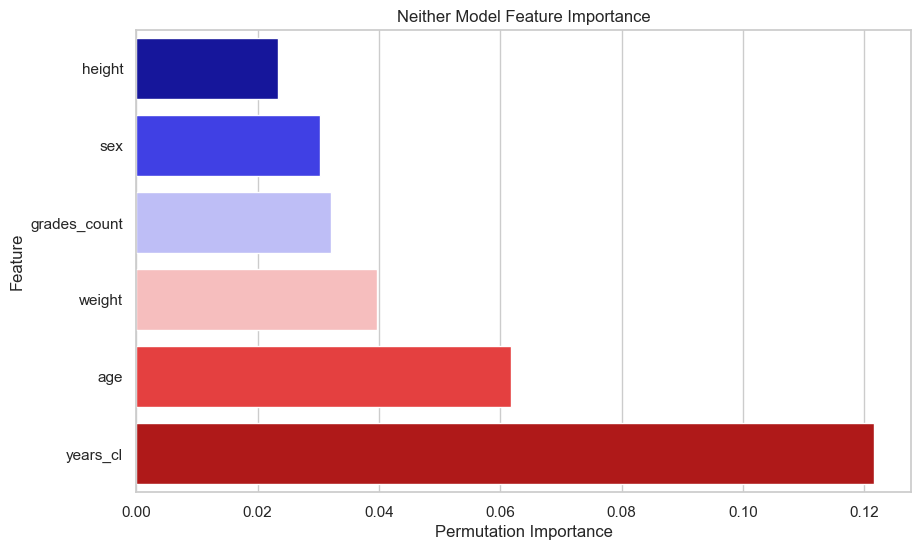

In [18]:
from sklearn.inspection import permutation_importance

result = permutation_importance(clf, X, y, n_repeats=10, random_state=0)
sorted_idx = result.importances_mean.argsort()

perm_importance_df = pd.DataFrame({'Feature': np.array(features)[sorted_idx],
                                   'Importance': result.importances_mean[sorted_idx]})
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette='seismic')
plt.xlabel('Permutation Importance')
plt.title('Neither Model Feature Importance')
plt.savefig('perm_imp_knn_neither.png')
plt.show()

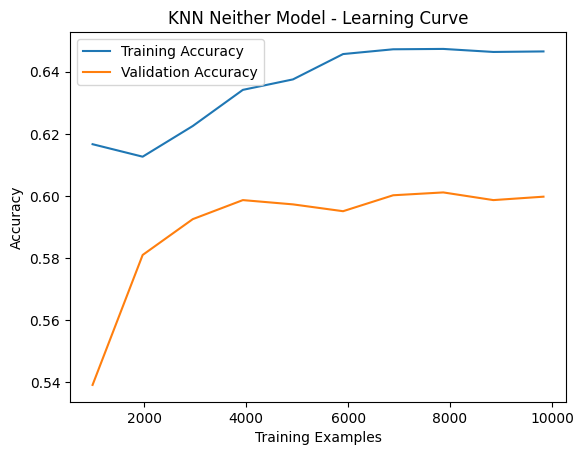

In [29]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy")

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('KNN Neither Model - Learning Curve')
plt.savefig("learning_curve_knn_neither.png")
plt.legend()
plt.show()

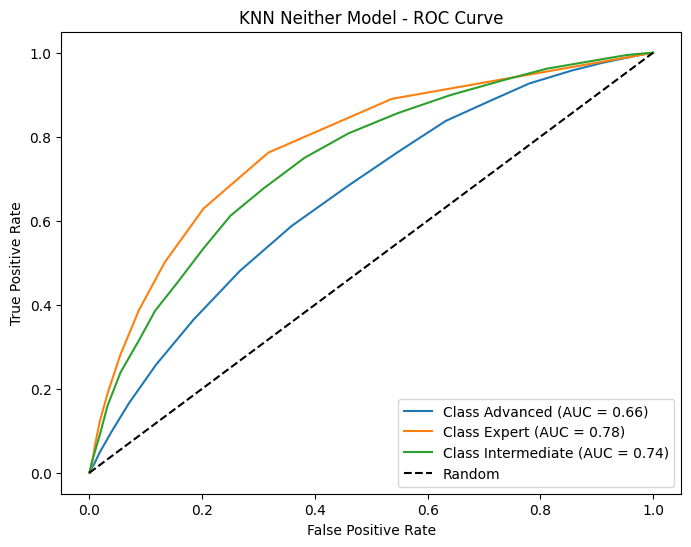

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=best_k))

y_numeric = label_encoder.fit_transform(y)
y_one_hot = label_binarize(y_numeric, classes=np.unique(y_numeric))
y_scores = cross_val_predict(clf, X, y_one_hot, cv=10, method="predict_proba")

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_one_hot[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label="Class {} (AUC = {:.2f})".format(label_encoder.inverse_transform([i])[0], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Neither Model - ROC Curve')
plt.legend()
plt.savefig("roc_neither_knn.png")
plt.show()

['Advanced' 'Expert' 'Intermediate']


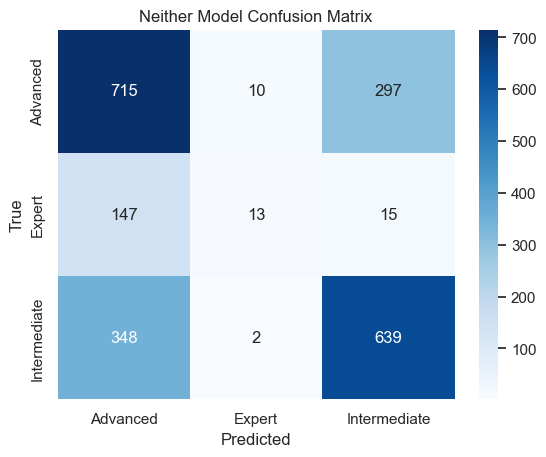

In [36]:
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predict)

print(np.unique(y))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",  xticklabels=['Advanced', 'Expert', 'Intermediate'], yticklabels=['Advanced', 'Expert', 'Intermediate'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Neither Model Confusion Matrix")
plt.savefig('neither_conf_heatmap.png')
plt.show()

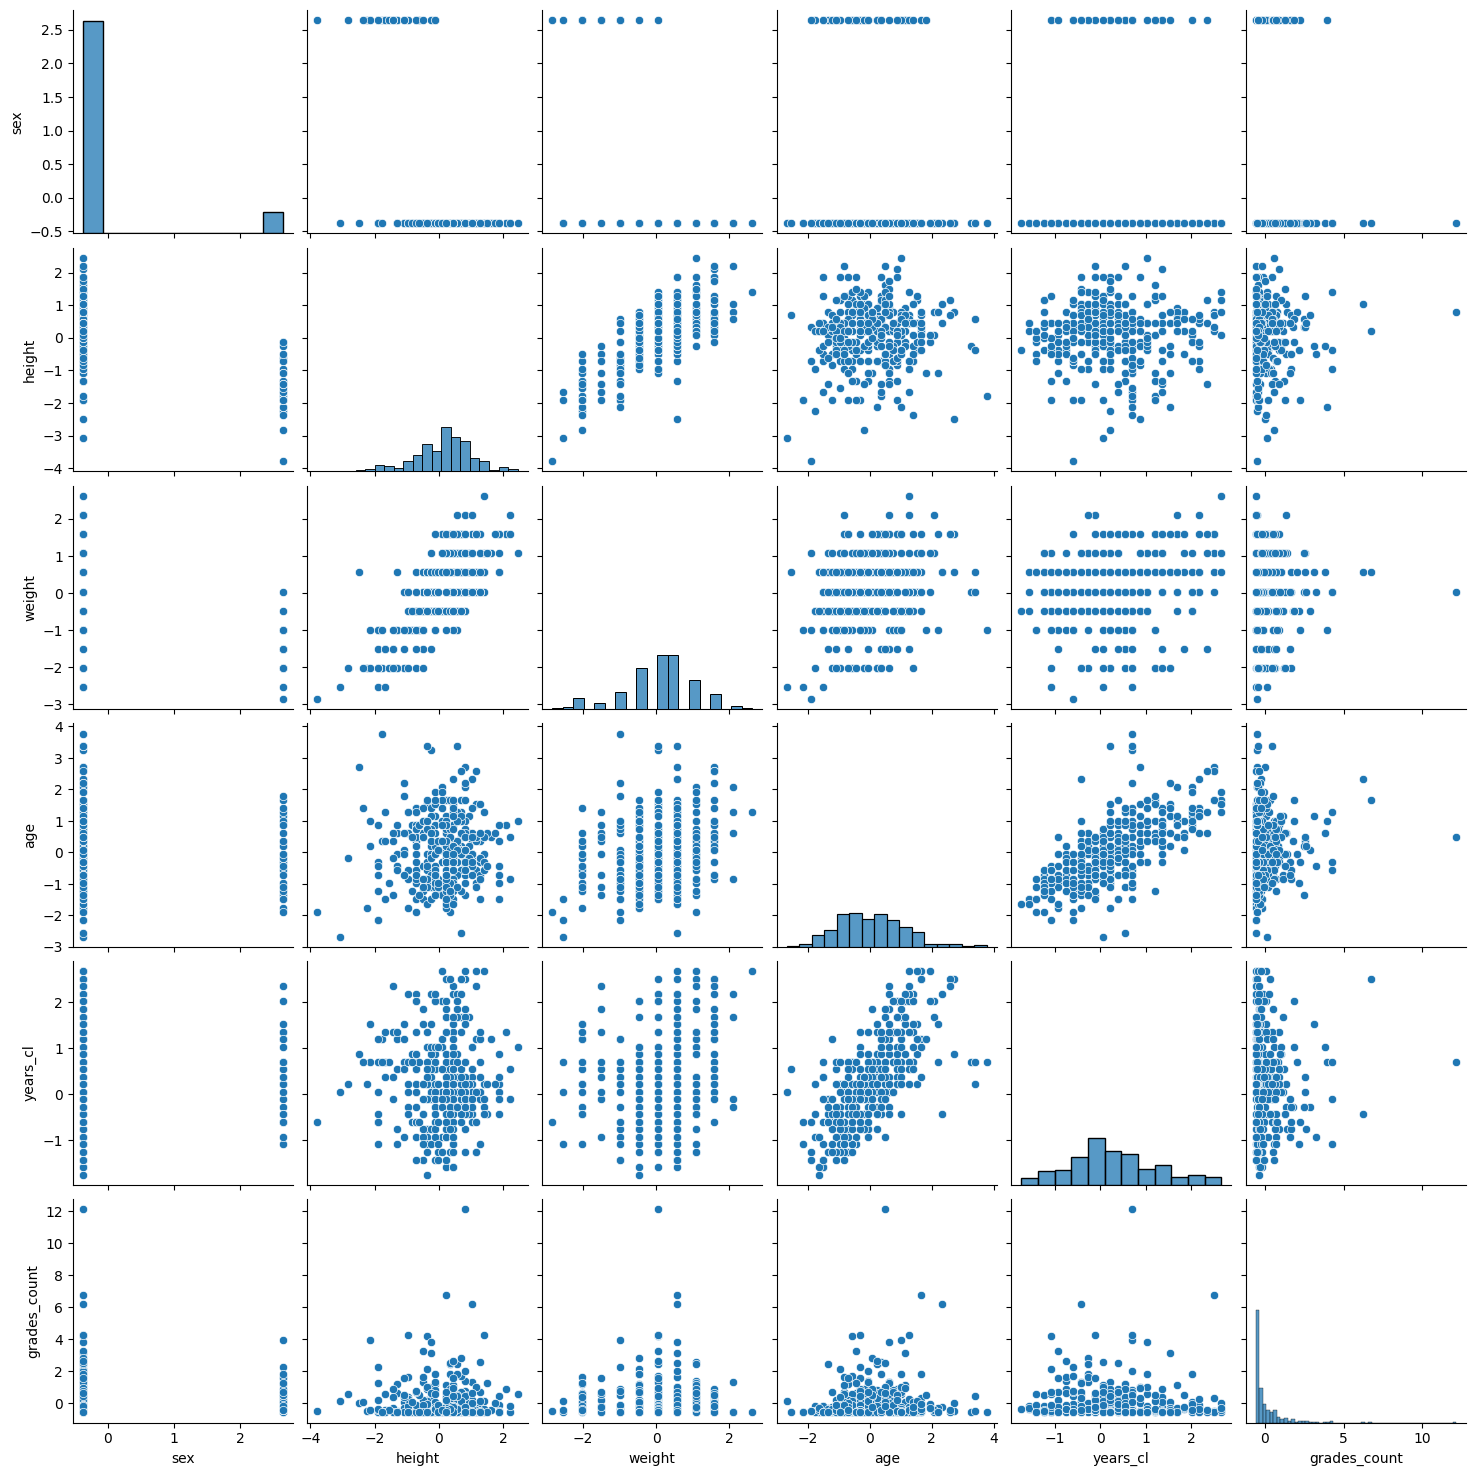

In [38]:
misclassified_indices = [i for i, (true_label, predicted_label) in enumerate(zip(y_test, y_predict)) if true_label == 'Intermediate' and predicted_label == 'Advanced']
misclassified_instances = X_test[misclassified_indices]
# print(y_predict)
columns = ['sex', 'height', 'weight', 'age', 'years_cl', 'grades_count']
df_misclassified = pd.DataFrame(misclassified_instances, columns=columns)
sns.pairplot(df_misclassified, markers='o')
plt.savefig('neight_misclassified_adv_pairplot.png')
plt.show()

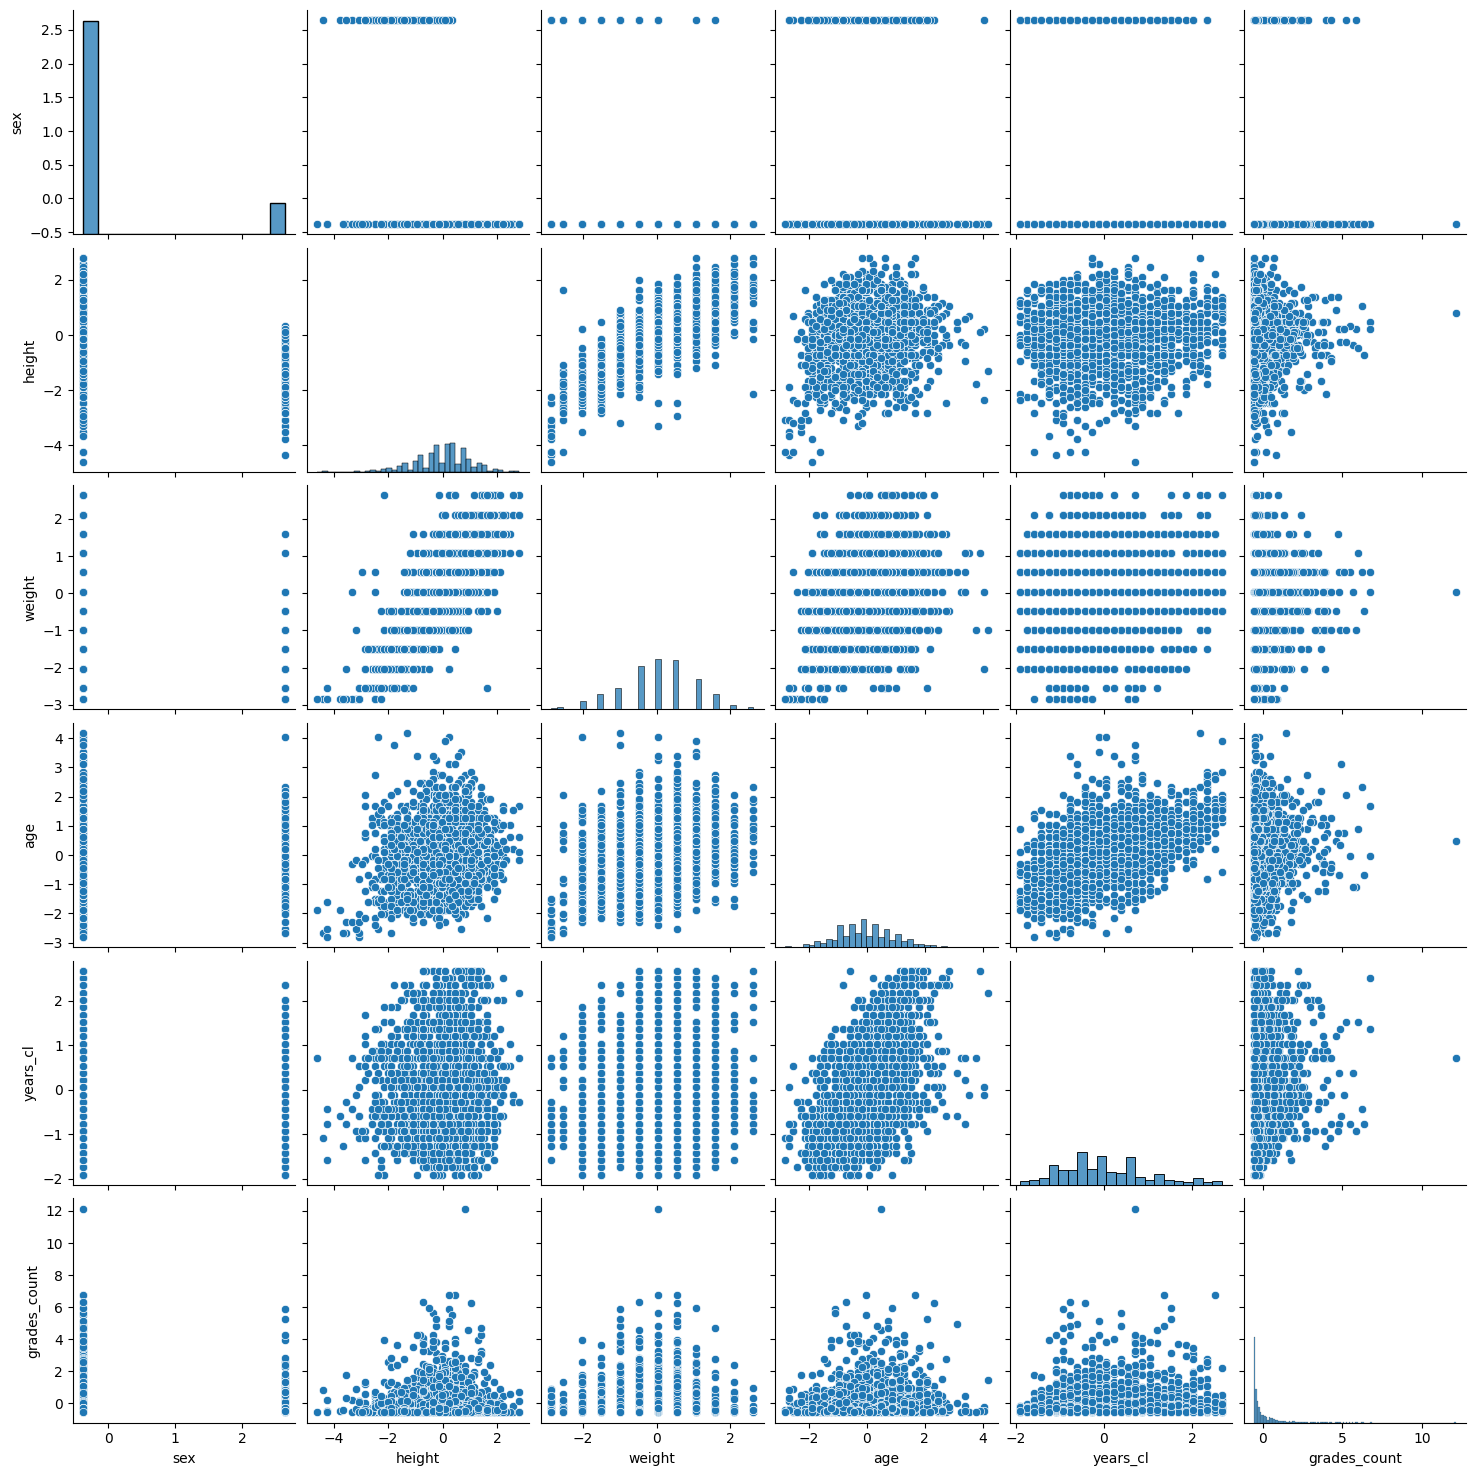

In [43]:
df = pd.DataFrame(X_test, columns = ['sex', 'height', 'weight', 'age', 'years_cl', 'grades_count'])
sns.pairplot(df, markers='o')
plt.savefig('neither_full_pairplot.png')
plt.show()

In [33]:
merged_df = pd.concat([both, first, maxi, neither], keys=['Both', 'Only grades_first', 'Only grades_max', 'Neither'])

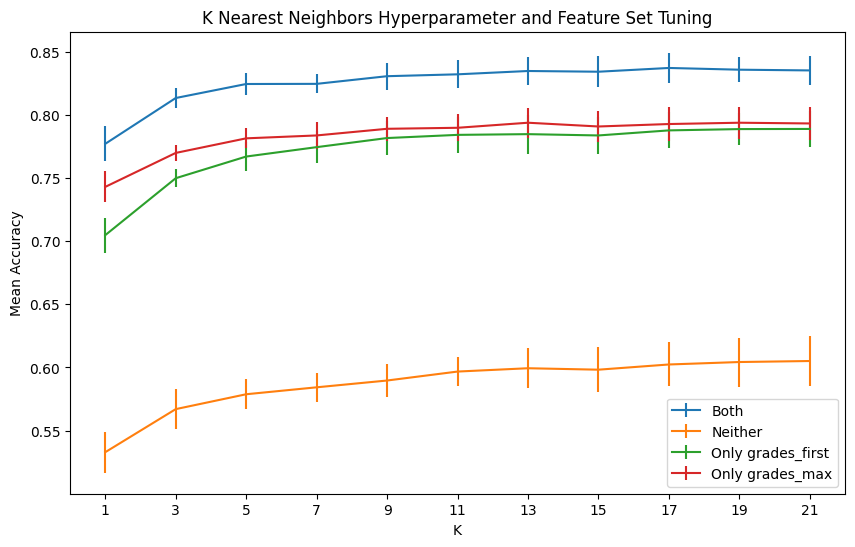

In [34]:
plt.figure(figsize=(10, 6))  
for feature_set, data in merged_df.groupby(level=0):
    plt.errorbar(data['K'], data['Mean'], yerr=data['Standard Deviation'], label=feature_set)

plt.xlabel('K')
plt.ylabel('Mean Accuracy')
plt.title('K Nearest Neighbors Hyperparameter and Feature Set Tuning')
plt.legend()
plt.xticks(range(1, 22, 2))

plt.savefig('knn_feature_tuning.png')
plt.show()

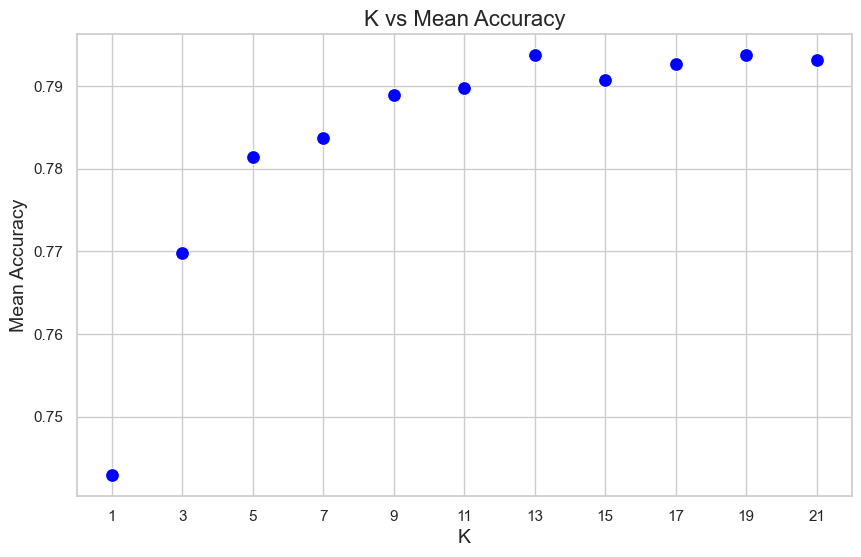

In [13]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=maxi['K'], y=maxi['Mean'], color='blue', s=100)

plt.title('K vs Mean Accuracy', fontsize=16)
plt.xlabel('K', fontsize=14)
plt.ylabel('Mean Accuracy', fontsize=14)
plt.xticks(range(1, 22, 2))
plt.savefig('k_vs_max_acc.png')
plt.show()